In [2]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 0


In [3]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [4]:
#Data Samples
#DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

#TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
#filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
#batch_size = 128
#train_set_size = int((5*10e5//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

In [6]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
#filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
filename_bg = DATA_PATH + 'QCD_training_data_100const_03_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [7]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

res_width = 'BROAD,NARROW'.split(',')
res_mass = '1.5,3.5'.split(',')
particles_sig_dict = {}

for width in res_width:
    for mass in res_mass:  
        SIG_NAME = 'RSGraviton_WW_'+width+'_13TeV_PU40_'+mass+'TeV_NEW'
        filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
        _,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)
        particles_sig_dict['Graviton '+width+' '+mass] = particles_sig
signal_types = list(particles_sig_dict.keys())        

/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 9890
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9969
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


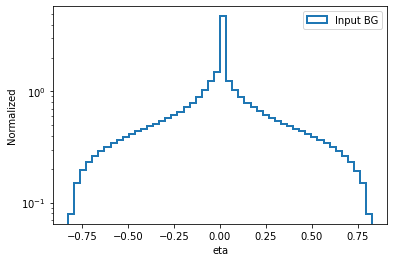

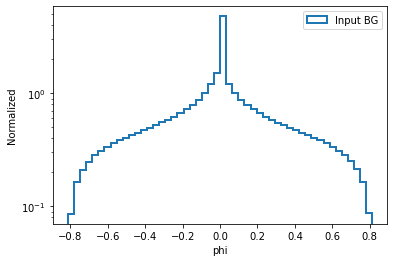

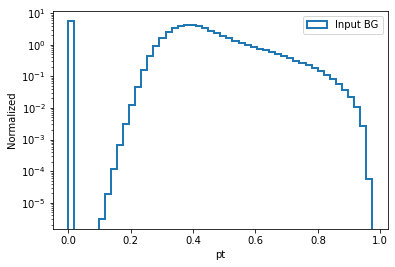

In [8]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [185]:
import tensorflow.keras.layers as klayers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

# Particle Net AE

In [204]:
class _DotDict:
    pass

setting = _DotDict()
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
  #  (30, (64, 64, 64)),
  #  (20, ([32])),
   (15, ([20,20,20])),
  #  (4, ([6])),

 #   (7, (10, 10, 10)),
 #   (7, [10]),
 #       (7, (8, 12, 18)),
 #       (20, (25, 40, 64)),
 #       (30, (64,70, 70)),
 #       (7, (32, 32, 32)),
 #       (7, (64, 64, 64)),
        ]
#setting.conv_params_decoder = [60,32,16,8, 5]
setting.conv_params_encoder_input = 20
setting.conv_params_decoder = [20]  #[32,16,8]
setting.with_bn = True
# conv_pooling: 'average' or 'max'
setting.conv_pooling = 'average'
setting.conv_linking = 'concat' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 10
setting.ae_type = 'ae'  #ae or vae 
setting.beta_kl = 10
setting.kl_warmup_time = 0
setting.activation = klayers.LeakyReLU(alpha=0.1)


In [205]:
model = pnae.PNVAE(setting=setting,name='PN_AE_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 100, 2)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_66 (Tenso [(None, 2, 100)]     0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul_174 (TensorFlow [(None, 100, 2)]     0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_BatchMatMulV2_33 (T [(None, 100, 100)]   0           points[0][0]       

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 2000)              22000     
_________________________________________________________________
PN_AE__dense_0 (BatchNormali (None, 2000)              8000      
_________________________________________________________________
PN_AE__act_0 (Activation)    (None, 2000)              0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 100, 20)           0         
_________________________________________________________________
tf_op_layer_ExpandDims_155 ( [(None, 100, 1, 20)]      0         
_________________________________________________________________
PN_AE__conv_out (Conv2D)     (None, 100, 1, 3)         63  

In [206]:
optim = Adam(learning_rate=0.01)

model.compile(optimizer=optim)

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

kl_beta_callback = models.KLWarmupCallback()   


history = model.fit((particles_bg[:10000,:,0:2], particles_bg[:10000,:,:]) ,  particles_bg[:10000,:,:],
                    validation_data = ((particles_bg_valid[:10000,:,0:2], particles_bg_valid[:10000,:,:]) , particles_bg_valid[:10000,:,:]),
                    epochs=30, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls])#,kl_beta_callback])



Epoch 1/30
79/79 [==============================] - 4s 50ms/step - loss: 0.0596 - val_loss: 0.0218
Epoch 2/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0206 - val_loss: 0.0202
Epoch 3/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0198 - val_loss: 0.0188
Epoch 4/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 5/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0192 - val_loss: 0.0183
Epoch 6/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0188 - val_loss: 0.0195
Epoch 7/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 8/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0186 - val_loss: 0.0177
Epoch 9/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 10/30
79/79 [==============================] - 4s 45ms/step - loss: 0.0185 - val_loss: 0.0179
Epoch 11/

In [ ]:
models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
model_path = models_dir + "output_model_saved_PN_AE_2021_08_02_T_15_52"
#"output_model_saved_PN_VAE_2021_08_02_T_13_31"
#"output_model_saved_PN_AE_2021_08_02_T_15_52"
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={"PN_AE": pnae.PNVAE, "threeD_loss":losses.threeD_loss}
)
weights_path = models_dir + "PN_AE_weights_2021_08_02_T_15_52.18-0.022.hdf5"
#"PN_VAE_weights_2021_08_02_T_13_31.04-0.033.hdf5"
#'PN_AE_weights_2021_08_02_T_15_52.12-0.022.hdf5'
loaded_model.load_weights(
    weights_path, by_name=True, skip_mismatch=False)

In [207]:
#model = loaded_model
particles_sig_dict['predicted'] = {}
latent_space_bg,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
for sig in signal_types:
    latent_space_sig,Y_sig_predict = model.predict([particles_sig_dict[sig][:,:,0:2],particles_sig_dict[sig]])
    particles_sig_dict['predicted'][sig] = {}
    particles_sig_dict['predicted'][sig]['latent_space'] = latent_space_sig
    particles_sig_dict['predicted'][sig]['Y_sig_predict'] = Y_sig_predict

In [208]:
#import copy
#sig_out_of_phase_space = copy.deepcopy(particles_sig)
#sig_out_of_phase_space[:,:,2] = sig_out_of_phase_space[:,:,2] +0.5
#_,Y_sig_out_of_phase_space_predict = model.predict([sig_out_of_phase_space[:,:,0:2],sig_out_of_phase_space])

In [209]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
particles_sig_dict['loss'] = {}
for sig in signal_types:
    particles_sig_dict['loss'][sig] = losses.threeD_loss_manual(particles_sig_dict[sig],particles_sig_dict['predicted'][sig]['Y_sig_predict'])

#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)



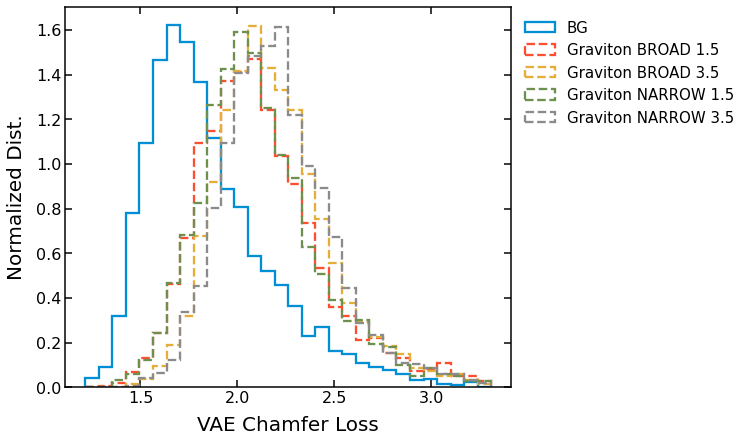

In [210]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = 1.1*np.quantile(loss_bg,0.99)
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
for sig in signal_types:
    plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_loss_pn_ae.pdf'
plt.savefig(savename)
plt.show()

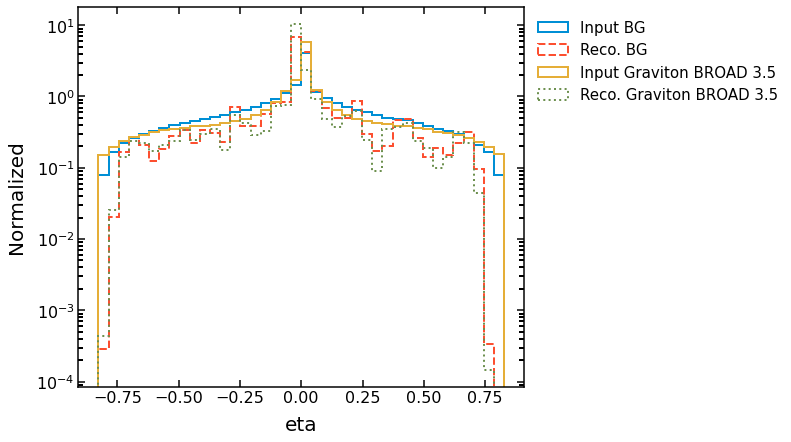

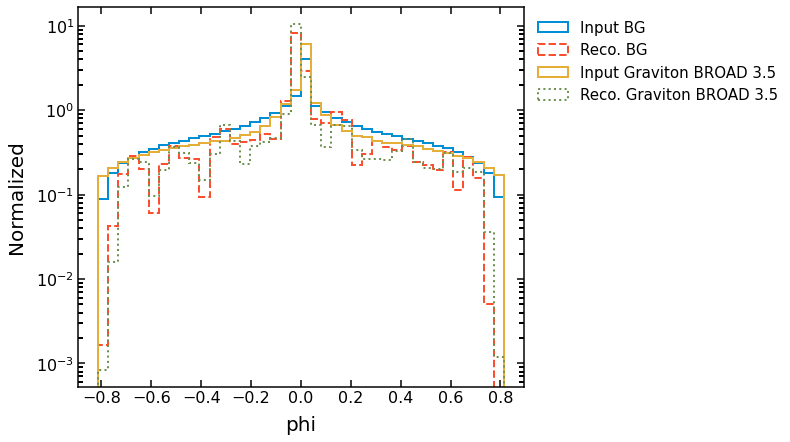

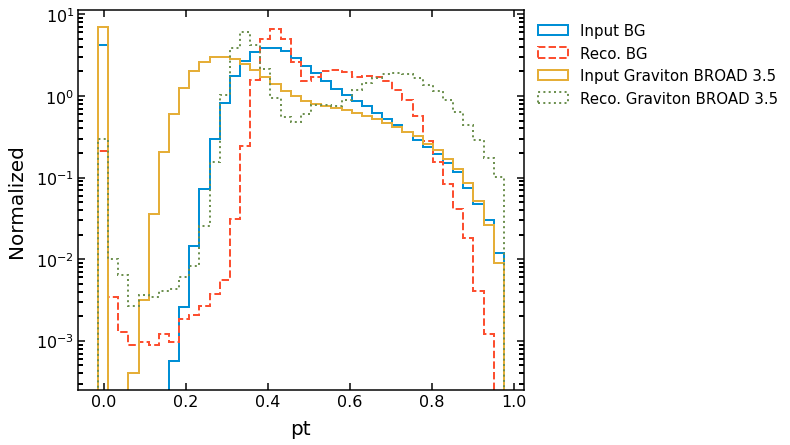

In [211]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    for sig in signal_types[1:2]:       
        _,_,_ = plt.hist(particles_sig_dict[sig][:,:,i].flatten(), bins=bins, label='Input '+sig,density=True, histtype='step', fill=False, linewidth=2)
        _,_,_ = plt.hist(particles_sig_dict['predicted'][sig]['Y_sig_predict'][:,:,i].flatten(), bins=bins, label='Reco. '+sig, linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_vars_pn_ae_{}.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


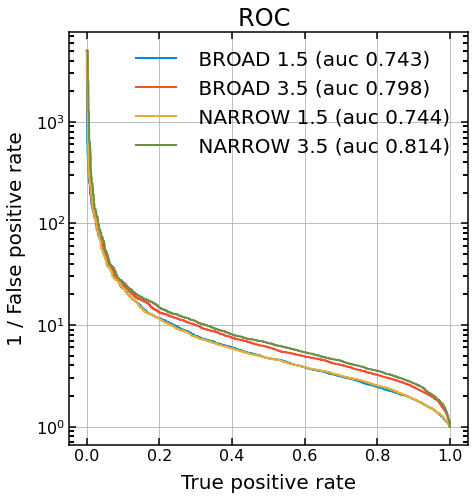

[0.7425624000000001, 0.7982838200000001, 0.74423788, 0.81364536]

In [212]:
neg_class_losses = [loss_bg.tolist()]*len(signal_types)
pos_class_losses = []
for sig in signal_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig])

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in signal_types], title='ROC ',
            plot_name='ROC_pn_ae_signals', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [207]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))


In [208]:
import plotly.express as px
import plotly.graph_objects as go

In [110]:
fig = go.Figure([
        go.Scatter3d(
            name='BG',
            x=latent_space_bg[0][:,0],
            y=latent_space_bg[1][:,1],
            z=latent_space_bg[2][:,2],
            mode='markers', opacity=0.3,
            hovertemplate
            ="x: %{x:0.2f}<br>y: %{z:0.2f}<br>z: %{y:0.2f}<br>",
            showlegend=True
            ),
        go.Scatter3d(
            name='SIG',
            x=latent_space_sig[0][:,0],
            y=latent_space_sig[1][:,1],
            z=latent_space_sig[2][:,2],
            mode='markers', opacity=0.3,
            hovertemplate
            ="x: %{x:0.2f}<br>y: %{z:0.2f}<br>z: %{y:0.2f}<br>",
            showlegend=True
            ),
    ]
    )
fig.show()

IndexError: too many indices for array